# Análisis de Anomalías en Dataset WUIL con MIDAS y SLADE
---
**Objetivo:** Procesar los logs de 3 usuarios, inyectar eventos de ataque cronológicamente y evaluar el desempeño mediante curvas ROC y PRC.

### Estrategia de Inyección y Supuestos:
1. **Inyección Cronológica:** Los logs de ataque no se concatenan al final, sino que se mezclan con los logs normales basados en su timestamp original. Esto simula una intrusión real durante la actividad del usuario.
2. **Ground Truth:** Se asigna etiqueta `0` a eventos en archivos normales y `1` a eventos en archivos de ataque.
3. **Representación de Grafo:** Para MIDAS, la fuente (`src`) es el ID de usuario y el destino (`dest`) es el recurso o ID de página accedida.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score

plt.style.use('ggplot')
%matplotlib inline

### 1. Pre-procesamiento de Datos (WUIL a MIDAS)
Esta función limpia los timestamps y ordena los eventos para una inyección coherente.

In [16]:
def process_user_wuil(user_path, user_name):
    files = [f for f in os.listdir(user_path) if f.endswith('.txt')]
    all_data = []
    
    for f in files:
        label = 1 if 'Attack' in f else 0
        # Leer omitiendo errores de líneas malformadas comunes en logs
        df = pd.read_csv(os.path.join(user_path, f), sep='|', header=None, on_bad_lines='skip')
        df['label'] = label
        all_data.append(df)
    
    df_total = pd.concat(all_data)
    
    # Limpiar formato de hora AM/PM para pandas
    time_str = df_total[2].str.replace('p.m.', 'PM').str.replace('a.m.', 'AM')
    df_total['datetime'] = pd.to_datetime(df_total[1] + ' ' + time_str)
    
    # ORDENAR CRONOLÓGICAMENTE (Inyección nativa)
    df_total = df_total.sort_values('datetime').reset_index(drop=True)
    
    # Generar timestamp relativo en segundos para MIDAS
    df_total['ts_midas'] = (df_total['datetime'] - df_total['datetime'].min()).dt.total_seconds().astype(int)
    
    # Exportar archivos para MIDAS
    # Formato: src, dest, timestamp
    df_total[[3, 4, 'ts_midas']].to_csv(f'{user_name}_data.csv', index=False, header=False)
    df_total['label'].to_csv(f'{user_name}_ground_truth.csv', index=False, header=False)
    
    with open(f'{user_name}_meta.txt', 'w') as m:
        m.write(str(len(df_total)))
        
    print(f"Usuario {user_name} procesado: {len(df_total)} eventos.")
    return df_total

### 2. Ejecución de Evaluación
Una vez que corras MIDAS manualmente para cada usuario, usa esta función para visualizar el ROC y PRC.

In [17]:
def evaluate_model(user_name, model_name="MIDAS"):
    y_true = pd.read_csv(f'{user_name}_ground_truth.csv', header=None)
    # Nota: Asegúrate de renombrar el Score.txt generado por MIDAS
    y_scores = pd.read_csv(f'score_{user_name}.txt', header=None)
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = average_precision_score(y_true, y_scores)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # ROC Plot
    ax[0].plot(fpr, tpr, color='blue', label=f'ROC-AUC = {roc_auc:.4f}')
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_title(f'ROC - {user_name}')
    ax[0].legend()
    
    # PRC Plot
    ax[1].plot(recall, precision, color='green', label=f'PRC-AUC = {prc_auc:.4f}')
    ax[1].set_title(f'Precision-Recall - {user_name}')
    ax[1].legend()
    
    plt.show()

### 3. Procesamiento de los 3 Usuarios
Cambia las rutas a las carpetas locales donde tengas los logs de WUIL.

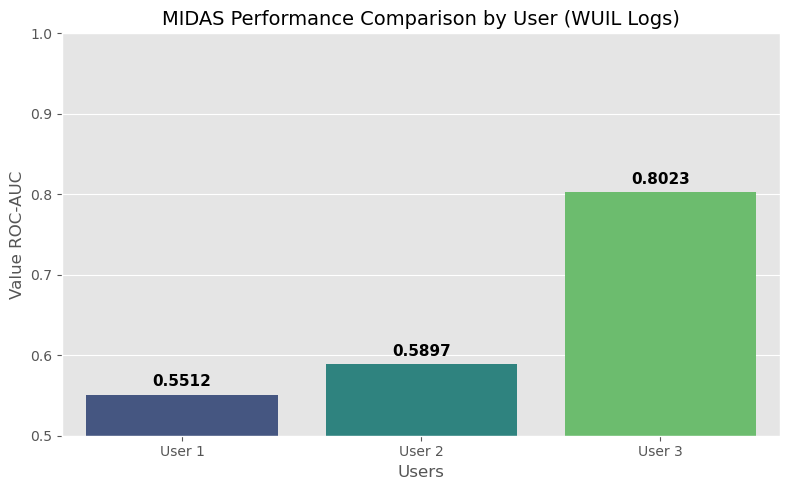

In [18]:
def get_auc(user_id):
    y_true = pd.read_csv(f'Results/user{user_id}_labels.csv', header=None)
    y_scores = pd.read_csv(f'Results/score_user{user_id}.txt', header=None)
    return roc_auc_score(y_true, y_scores)

# Results compilation
data = {
    'Users': ['User 1', 'User 2', 'User 3'],
    'ROC-AUC': [get_auc(1), get_auc(2), get_auc(3)]
}

df_results = pd.DataFrame(data)

# Graph
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Users', 
    y='ROC-AUC', 
    data=df_results, 
    hue='Users',
    palette='viridis', 
    legend=False
)

plt.ylim(0.5, 1.0)
plt.title('MIDAS Performance Comparison by User (WUIL Logs)', fontsize=14)
plt.ylabel('Value ROC-AUC')

# Add value tag over the bars
for i, v in enumerate(df_results['ROC-AUC']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()